# CS304 - Project 4: Spell Checker

- Authors: Junkai Man, Tzu-Liang Huang
- Feb 16, 2022
- Slides link: https://docs.google.com/presentation/d/1eaB3l2l5xjz0I-Ho9y5Y55IVOjlLuhqA4UOOwHNosF4/edit#slide=id.g115101b7aff_1_0

## Outline
1. LexTree
2. Spell checker on single word
3. Spell checker on unsegmented text

## 1. LexTree

### 1.1 Node class

In [2]:
import numpy as np
class Node:
    def __init__(self, val, property=1):
        self.val = val
        self.prev = []          # list of previous nodes
        self.next = []          # list of next nodes
        self.nextProb = []      # store the transition probability to go to next node
        # 0: start node, 1: normal node, 2: end node
        self.property = property

    def __str__(self):
        return self.val

    def _pretty_str(self, level=0):
        ret = "\t" * level + repr(self.val) + "\n"
        for nextNode in self.next:
            ret += nextNode._pretty_str(level=level + 1)
        return ret
    
    def pprint(self):
        print(self._pretty_str())
    
    def append_prev(self, prevNode):
        assert type(prevNode) is Node
        if prevNode not in self.prev:
            self.prev.append(prevNode)
            prevNode.append_next(self)

    def append_next(self, nextNode):
        assert type(nextNode) is Node
        if nextNode not in self.next:
            self.next.append(nextNode)
            nextNode.append_prev(self)
    
    def get_prev(self):
        return self.prev
    
    def get_next(self):
        return self.next

    def _get_root(self, level=0):
        if self.property == 0:
            return (level, self)

        root_levels = [prevNode._get_root(level=level+1) for prevNode in self.prev]
        return max(root_levels, key=lambda x: x[0])

    def get_root(self):
        return self._get_root()[1]    # return the instance of node instead of root_level



### 1.2 Build Lex tree from the dictionary

In [3]:
def _build_tree(parent: Node, words, i, max_word_len):
    if i >= max_word_len or parent.property == 2:
        return
    
    for word in words:
        # Ensure each leaf uniquely identifies a word
        if (i + 1 < max_word_len and word[i + 1] == ' ') or i == max_word_len - 1:
            child = Node(word[i], property=2)
            parent.append_next(child)
            words.remove(word)
            
    # get unique chars
    chars = set(word[i] for word in words)
    for char in chars:
        child = Node(char, property=1)
        parent.append_next(child)
        new_words = [x for x in words if x[i] == char]
        _build_tree(child, new_words, i+1, max_word_len)


def build_tree_from_dict(words):
    """ Build the lexical tree from a Python list of the dictionary of words.
    """

    # Pad words to the same length
    word_lens = [len(w) for w in words]
    max_word_len = max(word_lens)
    for i, word in enumerate(words):
        words[i] = word.ljust(max_word_len, ' ')

    tree = Node('*', property=0)
    _build_tree(tree, words, 0, max_word_len)
    return tree

Preview of what a tree looks like:

In [8]:
words = ['bat', 'banana', 'battle', 'apple', 'app', 'alice']
preview_tree = build_tree_from_dict(words)
preview_tree.pprint()

'*'
	'a'
		'p'
			'p'
			'p'
				'l'
					'e'
		'l'
			'i'
				'c'
					'e'
	'b'
		'a'
			't'
			't'
				't'
					'l'
						'e'
			'n'
				'a'
					'n'
						'a'



### 1.3 Read dictionary file and build the tree

In [ ]:
with open('dict_1.txt', 'r', encoding='cp1252') as f:
    dict_list = f.read().splitlines()

dict_list[-5:]
dictionary = build_tree_from_dict(dict_list)

## 2. Spell Check on Single Word

In [ ]:
import numpy as np

def get_nodes(node_list, lexnode):
    node_list.append(lexnode)
    if len(lexnode.next) == 0:
        return
    for c in lexnode.next:
        get_nodes(node_list, c)

def spell_check_each_word(string_list: list, tree: Node, pruning=False, pruning_T=10):
    insertion_cost = 1.0
    deletion_cost = 1.0
    match_cost = 0.0
    substitution_cost = 1.0

    assert type(tree) is Node
    nodes = []
    get_nodes(nodes, tree)

    # initialize cost matrix
    n_rows = len(nodes)
    
    activation_arr = [True for _ in range(n_rows)]
    parent_index_arr = np.zeros(n_rows, dtype=int)
    word_ends_arr = []
    for r in range(n_rows):
        char = nodes[r]
        if char.property == 2:
            word_ends_arr.append(r)
        if len(char.get_next()) > 0:
            for nextNode in char.get_next():
                parent_index_arr[nodes.index(nextNode)] = r

    word_ends = []
    for i in range(n_rows):
        if nodes[i].property == 2:
            word_ends.append(i)
    
    best_costs = []
    matched_strings = []

    for string in string_list:
        string = "*" + string
        n_cols = len(string)
        cost_mat = np.full((n_rows, n_cols), np.inf)
        cost_mat[0, :] = 0
        traceback_mat = np.zeros((n_rows, n_cols), dtype=tuple)
        for i in range(n_cols):
            for j in range(n_rows):
                traceback_mat[j, i] = (0, 0)


        ## DP
        for c in range(n_cols):
            for r in range(n_rows):
                # dummy
                if c == 0 and r == 0:
                    continue
                if pruning and activation_arr[r] == False:
                    continue
                subcosts = [np.inf for _ in range(4)]
                from_points = [(0, 0) for _ in range(4)]

                # subcosts[0]: insertion ->
                # subcosts[1]: deletion ⬆️
                # subcosts[2]: substitution / match
            
                node_cost = int(string[c] != nodes[r].val)

                if nodes[r].property != 0:               # only if it's not dummy 
                    parent_index = parent_index_arr[r]
                else:
                    parent_index = None

                if c == 1:
                    subcosts[1] = node_cost + deletion_cost
                    from_points[1] = (r, c)
                    
                    subcosts[2] = node_cost + match_cost
                    from_points[2] = (r, c)
                elif parent_index is not None:
                    subcosts[0] = node_cost + insertion_cost + cost_mat[r, c-1]
                    subcosts[1] = node_cost + deletion_cost + cost_mat[parent_index, c]
                    if nodes[r].val == string[c]:
                        subcosts[2] = node_cost + match_cost + cost_mat[parent_index, c-1]
                    else:
                        subcosts[2] = node_cost + substitution_cost + cost_mat[parent_index, c-1]
                    
                    from_points[0] = (r, c-1)
                    from_points[1] = (parent_index, c)
                    from_points[2] = (parent_index, c-1)
                
                min_idx = np.argmin(subcosts)
                traceback_mat[r, c] = from_points[min_idx]
                cost_mat[r, c] = subcosts[min_idx]

            if pruning:
                optimized_cost = np.min(cost_mat[1:, c])
                for r in range(1, n_rows):
                    if cost_mat[r, c] > optimized_cost + pruning_T:
                        activation_arr[r] = False

        word_subcosts = [cost_mat[word_end, n_cols - 1] for word_end in word_ends]
        min_idx = np.argmin(word_subcosts)
        min_word_end = word_ends[min_idx]
        best_cost = word_subcosts[min_idx]

        c = n_cols - 1
        r = min_word_end
        matched_string = nodes[r].val
        while 1:
            if c == 1:
                break
            r, c = traceback_mat[r, c]
            if r != 0:
                matched_string += nodes[r].val
        best_costs.append(best_cost)
        matched_strings.append(matched_string[::-1])
        print(best_cost, matched_string[::-1])
    return best_costs, matched_strings

In [ ]:
typos = """onse apon a tyme wile gramadatta ws kng of benares th bohisata kame to lif t the foot of he himlays as a konkey he greo stronge and sturdee big of fraem well to do an'd livd by a kervve of th rever bangese in a forrest haunt now at that tym there was a crokodylle dvelinge in th gnges the krocodle's maete saw the greate frame of the munkey and she conceeved a loanging to ete hs harte so she sed to her lord ser i dasyre to eet the huart of tht grate king of the munkees

dood vife sade the crukodyle i leev in the vatre and hee livse on dri land huw kan we kach him

dy huk or by cruk shee riplyd he mst be kot if i doan't get heem i shalt die

all ryte anserd th krukerdyle kunsoaling hr don't trable yrself i hav a plan i wil give yoo his hart to eet

so whn th bodhisutta wus sittink on th bank of th gnges aftr takin a drnk of watr the crokodyl droo nyar and seid sir monkee whay do yout liv on badd froots in this olde familyr plais on the odher syde of the ganges theare is no ennd to the mangoe trees and labooja brees wiht fruut sveet as oney is it not betr to kros overe ande hav alle kyndse of wilde fruot to eate

lore crokodil th hunkee ansert the gangees is deepe and wayde houw shll i gt akross

ife yoo want to goe i vill let yu sit apon my bakk and kary you over

the monkey trustd hm andt agrid come 'ere thn seid th cracidole up on mye back with yoo and up th monkey klymbd but whn the brokodile had swum a lyttl waye he plungd the monkey undr the vater

guod frend yoou ar letingk me sinnk craed the minkey wht is that fr

th brukodyl said you think i am crrying youe out of puret goode nachre not a bit of it my wyfe has a langink for youre heaert and i wante to gve it to hr to eate

freind said the monkee it is nyce of yoo to tel me whay if our hart weret hinside us when we go kjumpink amongk the trie tops it wuld be all nocked to peeces

wll whre do yoou keep it askd the krocodileee

the budhisata poynted out a fg trie with glasters of ryp friut standing not far ovf sie saidh he theare are our harts hangingk on yondr fige trie

if you willt showe me your beart said the mrocogyle then i won't kill gou

taeke mee to the treee dhen andd i wll poynt it out to youe

the crabotile brouggt hym to the playce the monkey leapt off his back and clymbynj hup the figg tree sat hupon it oh spilly crocerdile saith he you tought that thear were kreetures that kept theeir haerst in a treetope you are a foole and i hav outvited you you may kep your friut to yoreself yore body is greuat but you hav no sesne

and thenn to eksplain ths ideya he luttered the followin stanzaz

rose-apfle yack-friute mnageso toos akrosse the watr thear i see
enouff of thm i wnt thm not my figg is goode henoufh for me
graet is yuor boddy verliy butt how muchh smaller is yoru witt
now go youre ways ser crocodile for i hve hdd th besst hof ith
the crocrdile feelingg as sadd and myserablle as if he had lost a housand pieses of muney wnt backk zorrowingk to the plase wher he livd"""

In [ ]:
typo_list = typos.split()
best_costs, strings = spell_check_each_word(typo_list, dictionary, pruning=False, pruning_T=10)

## 3. Spell Check on unsegmented text

In [ ]:
def spell_check(string_list: list, dictionary: Node, pruning=False, pruning_T=1, d_cost=1.0, i_cost=1.0, m_cost=0.0, s_cost=1.0, sp_cost=0.0, l_cost=1.0):
    """
    Spell check a string using the given dictionary.
    """

    INSERTION_COST = i_cost     
    DELETION_COST = d_cost 
    MATCH_COST = m_cost
    SUBSTITUTION_COST = s_cost
    SPACE_COST = sp_cost
    LOOP_COST = l_cost

    # Create a list of all chracters in the dictionary.
    def append_char(nodes: list, root: Node):
        nodes.append(root)
        if len(root.get_next()) == 0:
            return
        for c in root.get_next():
            append_char(nodes, c)
    chars = []
    append_char(chars, dictionary)
    chars.append(Node(' ', property=0))     # append the blank space character
    
    # Record the leafs
    n_rows = len(chars)
    parent_index_arr = np.zeros(n_rows, dtype=int)
    word_ends_arr = []
    for r in range(n_rows):
        char = chars[r]
        if char.property == 2:
            word_ends_arr.append(r)
        if len(char.get_next()) > 0:
            for nextNode in char.get_next():
                parent_index_arr[chars.index(nextNode)] = r

    best_costs = []
    matched_strings = []

    #cost matrix
    #traceback matrix
    #pruning activation matrix

    for string in string_list:

        string = "*" + string
        n_cols = len(string)
        cost_mat = np.full((n_rows, n_cols), np.inf)
        cost_mat[0, :] = 0
        traceback_mat = np.zeros((n_rows, n_cols), dtype=tuple)
        for i in range(n_cols):
            for j in range(n_rows):
                traceback_mat[j, i] = (0, 0)
        activation_arr = [True for _ in range(n_rows)]


        # DP
        for c in range(n_cols):
            for r in range(n_rows):
                if r == 0 and c == 0:
                    continue
                if pruning and (activation_arr[r] == False):
                    continue

                subcosts = [np.inf for _ in range(4)]
                from_points = [(0, 0) for _ in range(4)]

                # 0 Insertion ->
                # 1 Deletion  ⬆️
                # 2 Match / Substitution  \diagonal
                # 3 Loop to dummy node      
                node_cost = int(string[c] != chars[r].val)
                
                if chars[r].property != 0:      # only if it's not dummy 
                    parent_index = parent_index_arr[r]
                else:
                    parent_index = None
                

                # if this is a space node
                if (r == n_rows - 1) and c > 0:
                    subcosts = [node_cost + SPACE_COST + cost_mat[word_end, c - 1] for word_end in word_ends_arr[1:]]
                    from_points = [(word_end, c - 1) for word_end in word_ends_arr[1:]]
                
                elif parent_index == 0:
                    if c > 0:
                        # insertion
                        subcosts[0] = node_cost + INSERTION_COST + cost_mat[r, c - 1]
                        from_points[0] = (r, c - 1)

                        # deletion
                        subcosts[1] = node_cost + DELETION_COST + cost_mat[parent_index, c]
                        from_points[1] = (parent_index, c)
                        
                        # match & substitution
                        if node_cost == 0:
                            subcosts[2] = node_cost + MATCH_COST + cost_mat[parent_index, c-1]
                        else:
                            subcosts[2] = node_cost + SUBSTITUTION_COST + cost_mat[parent_index, c-1]
                        from_points[2] = (parent_index, c - 1)

                elif r == 0:
                    if c > 0:
                        # calculate loop costs
                        loop_costs = [node_cost + LOOP_COST + cost_mat[n_rows - 1, c - 1]]

                        # find the lowest loop cost
                        loop_min_idx = np.argmin(loop_costs)
                        subcosts[3] = loop_costs[loop_min_idx]
                        from_points[3] = (n_rows - 1, c - 1)
                else:
                    if c > 0:
                        # insertion
                        subcosts[0] = node_cost + INSERTION_COST + cost_mat[r, c - 1]
                        from_points[0] = (r, c - 1)
                    
                    if parent_index is not None:
                        # deletion
                        subcosts[1] = node_cost + DELETION_COST + cost_mat[parent_index, c]
                        from_points[1] = (parent_index, c)

                    if parent_index is not None and c > 0:
                        # match & substitution
                        if node_cost == 0:
                            subcosts[2] = node_cost + MATCH_COST + cost_mat[parent_index, c - 1]
                        else:
                            subcosts[2] = node_cost + SUBSTITUTION_COST + cost_mat[parent_index, c - 1]
                        from_points[2] = (parent_index, c - 1)

                # remember path and cost
                min_idx = np.argmin(subcosts)
                cost_mat[r, c] = subcosts[min_idx]
                traceback_mat[r, c] = from_points[min_idx]
            
            if pruning:
                optimized_cost = np.min(cost_mat[1:-1, c])
                for r in range(1, n_rows-1):
                    if cost_mat[r, c] > optimized_cost + pruning_T:
                        activation_arr[r] = False

        subcosts = [cost_mat[word_end, n_cols - 1] for word_end in word_ends_arr]
        min_idx = np.argmin(subcosts)
        min_word_end = word_ends_arr[min_idx]
        best_cost = subcosts[min_idx]

        # find the matched string
        c = n_cols - 1
        r = min_word_end
        matched_string = chars[r].val
        while 1:
            if c == 0:
                break
            r, c = traceback_mat[r, c]
            if r != 0:
                matched_string += chars[r].val
            # else:
                # matched_strings += ' '
        # return best_cost, matched_string[::-1]
        # print(best_cost, matched_string[::-1])
        
        best_costs.append(best_cost)
        matched_strings.append(matched_string[::-1])
    return best_costs, matched_strings
                

In [ ]:
import time
startTime = time.time()
best_costs, matched_strings = spell_check(typo_list, dictionary, pruning=False, pruning_T=10)
endTime = time.time()

### 3.1 Unsegmented

In [ ]:
unsegmented = ["onceuponatimewhilebrahmadattawaskingofbenaresthebodhisattacametolifeatthefootofthehimalayasasamonkeyhegrewstrongandsturdybigofframewelltodoandlivedbyacurveoftherivergangesinaforesthauntnowatthattimetherewasacrocodiledwellinginthegangesthecrocodile'smatesawthegreatframeofthemonkeyandsheconceivedalongingtoeathisheartsoshesaidtoherlordsiridesiretoeattheheartofthatgreatkingofthemonkeysgoodwifesaidthecrocodileiliveinthewaterandhelivesondrylandhowcanwecatchhimbyhookorbycrooksherepliedhemustbecaughtifidon'tgethimishalldieallrightansweredthecrocodileconsolingherdon'ttroubleyourselfihaveaplaniwillgiveyouhishearttoeat"]

unsegmented_typo = ["onseaponatymewilegramadattawskngofbenaresthbohisatakametoliftthefootofhehimlaysasakonkeyhegreostrongeandsturdeebigoffraemwelltodoan'dlivdbyakervveofthreverbangeseinaforresthauntnowatthattymtherewasacrokodylledvelingeinthgngesthekrocodle'smaetesawthegreateframeofthemunkeyandsheconceevedaloangingtoetehshartesoshesedtoherlordseridasyretoeetthehuartofthtgratekingofthemunkeesdoodvifesadethecrukodyleileevinthevatreandheelivseondrilandhuwkanwekachhimdyhukorbycruksheeriplydhemstbekotifidoan'tgetheemishaltdieallryteanserdthkrukerdylekunsoalinghrdon'ttrableyrselfihavaplaniwilgiveyoohisharttoeet"]

segmented = """once upon a time while brahmadatta was king of benares the bodhisatta came to life at the foot of the himalayas as a monkey he grew strong and sturdy big of frame well to do and lived by a curve of the river ganges in a forest haunt now at that time there was a crocodile dwelling in the ganges the crocodile's mate saw the great frame of the monkey and she conceived a longing to eat his heart so she said to her lord sir i desire to eat the heart of that great king of the monkeys
good wife said the crocodile i live in the water and he lives on dry land how can we catch him
by hook or by crook she replied he must be caught if i don't get him i shall die
all right answered the crocodile consoling her don't trouble yourself i have a plan i will give you his heart to eat
so when the bodhisatta was sitting on the bank of the ganges after taking a drink of water the crocodile drew near and said sir monkey why do you live on bad fruits in this old familiar place on the other side of the ganges there is no end to the mango trees and labuja trees with fruit sweet as honey is it not better to cross over and have all kinds of wild fruit to eat"""

In [9]:
import string

In [10]:
def count_wrong(template, sample):
    
    puncts = string.punctuation
    puncts = puncts.replace("\n'",'')

    for punct in puncts:
        template = template.replace(punct, '')
    
    word_list = template.split()
    sample_list = sample.split()
    
    # score for difference number of segmented
    num_wrong_scores = abs(len(word_list)-len(sample_list))

    # score for wrong spelling word
    spell_wrong_scores = 0
    for i in sample_list:
        spell_wrong_scores += 1 if (i.lower() not in word_list) else 0
    
    return spell_wrong_scores + num_wrong_scores
    

In [ ]:
# result for unsegmented with no pruning, pruning = 5, 10, 15

sample_no = spell_check(unsegmented, dictionary, pruning=False)[1]
sample_5 = spell_check(unsegmented, dictionary, pruning=True, pruning_T=5)[1]
sample_10 = spell_check(unsegmented, dictionary, pruning=True, pruning_T=10)[1]
sample_15 = spell_check(unsegmented, dictionary, pruning=True, pruning_T=15)[1]

Results:

In [ ]:
sample_no = '''once o time i brahmadatta asking benaress bodhisatta me life thee tofu himalayass monkey grew ronna sturdyy offf ewell doo livedd curve thhrive gangess forest unknown that tether as crocodile well vint gangess crocodile oates theere frame them meeanns conceived longing death hearts he i overlordss desire eatt heart that eat nnoot monkey o wife iit crocodile live the toran elitess rylan o an catchh by odor crookk replied must caughtt don't the shall haaarig answeredd crocodile consolingg don't doub yourself area an i give oh heart eat'''
sample_5 = '''onne on i oh e oh outt an nno ee e e ooh ann an oo e oh o of ee an aaan onne e eee o an nu ee offf eeee o an i e ooor of ee e ann in or oh nnno oohh i oh e ooor oo e e i in eee ee e o e ee an an e e or e oh onn an e o e ee on no ee i eee o e i ohh or ii ee e e oh ee of an ee i of eee ee oo i e ii e oo i iii in e e an e e onnn an o an e ohh e o orrr ooooh ee e e e e ooh e onn e iii an i e ii an eeee e oo ii onn in e onnn oo e e e ii ee an ii ii o i e ee aa'''
sample_10 = '''once on i while thhad faw king beear thee hisao came life the ooonthe maaay as monney grew ronna sturc big frame leto and veda curve theeir gange lafooe haunt want ttime e was rooodin well vint gange he o diie oates theere frame them keea she once e longg to this artsss said serlo sir e ret att heart that e king them kea o wife iit croc ii live the torann livess rylan o an catchh by odor crook here died must oought icon get vissa diee right sweeeet croc i cons ing wwon't doub you ee have plan i give oh heart eat'''
sample_15 = '''once on i while raamada aaasking benares ee hisao came life the ooonthe malary as monkey grew ronna sturdyy offf ewell doo livedd curve thhrive gangess forest unknown that tether as rooodin well vint ganges euro diie oates theere frame them keea she once e longing death heartsss said serlo sir desire eatt heart that eat nnoot monkey o wife iit croc ii live the toran elitess rylan o an catchh by odor crookk replied must caughtt don't the shall ee right sweeeet croc i cons ingg don't doub yourself area an i give oh heart eat'''

In [ ]:
from matplotlib import pyplot as plt 
import matplotlib

In [ ]:
count_wrong_scores = []
sample_lst = [sample_no, sample_5, sample_10, sample_15]
for i in sample_lst:
    curr_score = count_wrong(segmented, i)
    count_wrong_scores.append(curr_score)

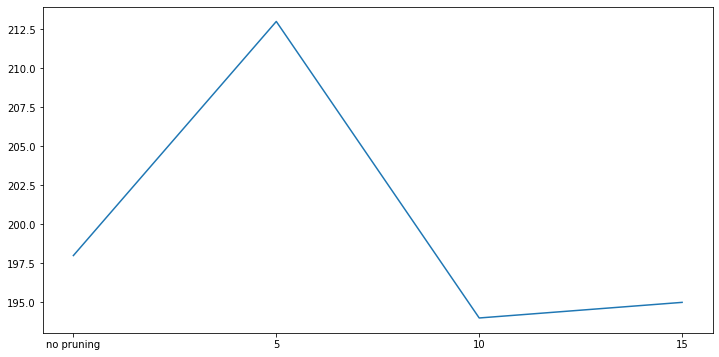

In [ ]:
plt.figure(figsize=(12,6))
sentiment, = plt.plot(['no pruning', '5', '10', '15'],count_wrong_scores)

### 3.3 Unsegmented + Typos

In [ ]:
# result for unsegmented_typo with no pruning, pruning = 5, 10, 15

sample_no_typo = spell_check(unsegmented_typo, dictionary, pruning=False)[1]
sample_5_typo = spell_check(unsegmented_typo, dictionary, pruning=True, pruning_T=5)[1]
sample_10_typo = spell_check(unsegmented_typo, dictionary, pruning=True, pruning_T=10)[1]
sample_15_typo = spell_check(unsegmented_typo, dictionary, pruning=True, pruning_T=15)[1]

Results:

In [ ]:
sample_no_typo = '''onne onnto will ramada aasking benares bodhisatta me liitt foot hhhimalayyas onneyyear strong nast deep off eewell doanna i by eevve threee annesee forrest unknown thatt the was crocodille elia into best kroc le maeees the eat frame them meeanns conceived hanging etc harter heeed serlo merida ret etc hua off grattting them keese ddicesare deeruko le eev the trranchees second land wwwnnek hhim husar crutcheer lyda sebek i doon't theem halts all teaase the kerry consooling don't ablee elfie fulani llive oh harttzeel'''
sample_5_typo = '''on up at ee e am at ass of no at oh at am o at e oooff i aasss o e e eee on an nu eee off e ee o ann i ee eee off eee an e in orr oh nnno at att oh e ass o ee e e in in on at or o ee aat am e e e am of e no an e on eeee oo in o ee aat ooh e ohh or ee as e eee e aat ohh at i of eee ee oo ii aaat or oo e e in e at an e ii on i nnnu ann am i oh or orrr e i ooh att oo i ann e e i aat e orr an aat e eee e nno innn on orr ee e ii aaaan i ii o i aat eee'''
sample_10_typo = '''onne onnto will rama teams goob are hao satt me liitt foot he mmayda kon theere tto ernnst deep off eewell dian live acero of rev gange in orr thad now thatt the was rojo lle elia into best kroc le maeees the eat frame them keea sssconc veda an nit teesh tesh heeed her ryser as e feett hua of oora king them keesee viies otheer o leal vint eat and elia onn land wwwnnek hhim hua byyrd heer lyda sebek i doon't theem halts all teaase the kerry duns king don't ablee elliia plann llive oh haro feet'''
sample_15_typo = '''onne onnto will ramada aasking benaress o satt me liitt foot he mmayda donkey or strong nast deep off eewell doanna i by eevve threee annesee forrest unknown thatt the was rojo lle elia into best kroc le maeees the eat frame them keea ssecond veda hanging etc harter heeed serlo merida ret etc hua off grattting them kies o i sad deeruko le eev the tree teel second land wwwnnek hhim hua by hasheer lyda sebek i doon't theem halts all teaase there roylee ssaling don't ablee elfie fulani llive oh harttzeel'''

In [ ]:
count_wrong_scores_typo = []
sample_lst = [sample_no_typo, sample_5_typo, sample_10_typo, sample_15_typo]
for i in sample_lst:
    curr_score = count_wrong(segmented, i)
    count_wrong_scores_typo.append(curr_score)

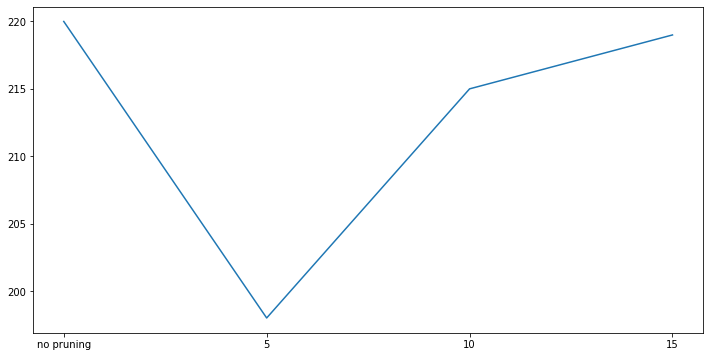

In [ ]:
plt.figure(figsize=(12,6))
sentiment, = plt.plot(['no pruning', '5', '10', '15'],count_wrong_scores_typo)